In [2]:
from google.colab import drive
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
!pip install kmodes

In [4]:
drive.mount('drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


## 1. Data

#### Read data

In [5]:
df_initial = pd.read_csv('drive/Team Drives/Marketing Analytics/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [6]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### Drop missing values

In [7]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


####Drop duplicates

In [8]:
print('duplicate record: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

duplicate record: 5225


In [9]:
df_initial.shape

(401604, 8)

### EDA

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
Description: Product (item) name. Nominal. 
Quantity: The quantities of each product (item) per transaction. Numeric. 
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
Country: Country name. Nominal, the name of the country where each customer resides.

In [10]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('# of countries orders were made: {}'.format(len(countries)))

# of countries orders were made: 37


In [11]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

#### identify unique number of users, products and transcations in these entries

In [12]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


4372 users and they bought 3684 different products. The total number of transactions carried out is 22,000.

#### number of products purchased in every transaction:

In [13]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:

the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled

the existence of users who only came once and only purchased one product (e.g. 12346)

the existence of frequent users that buy a large number of items at each order

####Canceled orders

In [14]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


In [15]:
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [16]:
cancel_invoice = nb_products_per_basket.InvoiceNo[nb_products_per_basket['order_canceled'] == 1].tolist()
df_cancel = df_initial.loc[df_initial['InvoiceNo'].isin(cancel_invoice)]
df_cancel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [0]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

The above function checked the two cases:

1.a cancel order exists without counterpart

2.at least one counterpart with the exact same quantity
respectively kept in the doubtfull_entry and entry_to_remove lists

In [18]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


delete all of these entries, which count respectively for  ∼ 1.4% and 0.2% of the dataframe entries.

Now check the number of entries that correspond to cancellations and that have not been deleted with the previous filter

In [19]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [20]:
df_cleaned.shape

(392857, 9)

#### StockCode contains letters

In [21]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [22]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

#### TotalPrice
create a new variable that indicates the total price of every purchase

In [23]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Each entry of above dataframe indicates prices for a single produc. Aggregate prices on a single order instead:

In [24]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


a global view according to total prices

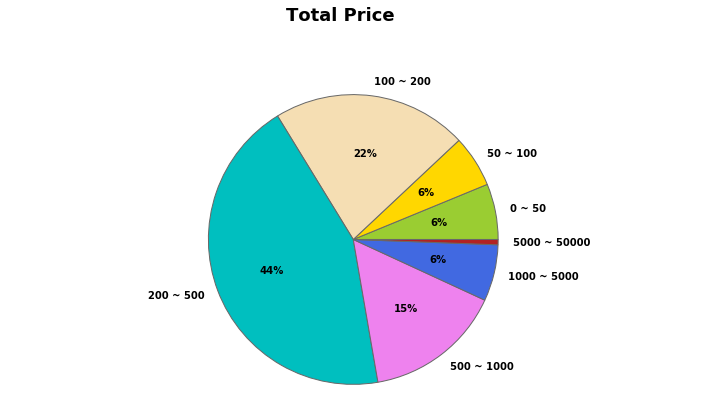

In [25]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{} ~ {}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Total Price", ha='center', fontsize = 18);

#### product categories

products are uniquely identified through the 'StockCode' variable and a shrort description is given in the 'Description' variable. Group the products into different categories.

extract the names (proper, common) appearing in the products description
for each name, extract the root of the word and aggregate the set of names associated with this particular root
count the number of times each root appears in the dataframe
when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [0]:
#define function

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [0]:
#retrieve the list of products:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [28]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Nb of keywords in variable 'Description': 1483


In [0]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

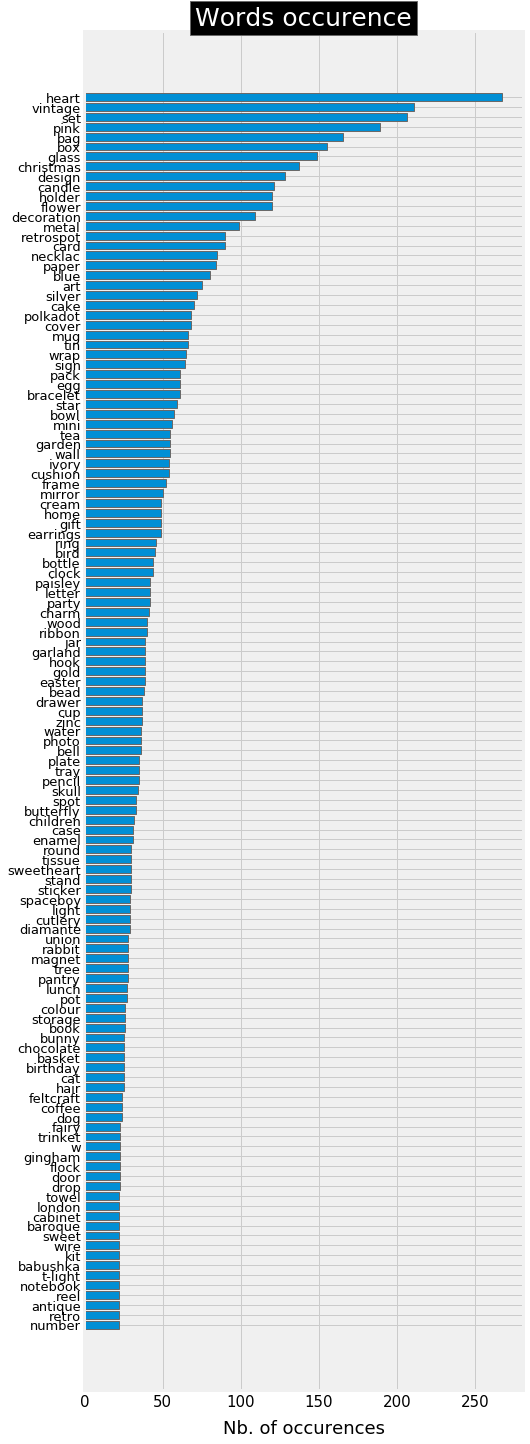

In [114]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

The list contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, some names are useless or do not carry information, like colors. Therefore, discard these words from the analysis that follows and also, consider only the words that appear more than 13 times.

In [30]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('most frequent word:', len(list_products))

most frequent word: 193


In [31]:
list_products[:10]

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120]]

In [0]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [33]:
X.head()

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,flower,decoration,metal,retrospot,card,necklac,paper,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,mirror,cream,...,travel,doilies,biscuit,regency,hen,jigsaw,rack,coaster,money,cottage,incense,crystal,medium,dish,image,picture,wooden,piece,bathroom,girl,fruit,childs,pan,food,orbit,alphabet,toadstool,time,milk,funky,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [35]:
X.head()

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,flower,decoration,metal,retrospot,card,necklac,paper,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,mirror,cream,...,rack,coaster,money,cottage,incense,crystal,medium,dish,image,picture,wooden,piece,bathroom,girl,fruit,childs,pan,food,orbit,alphabet,toadstool,time,milk,funky,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


In [37]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


Creating clusters of products

In [38]:
from kmodes.kmodes import KModes
for n_clusters in range(3,10):
  km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)

  clusters = km.fit_predict(X)

  silhouette_avg = silhouette_score(X, clusters)
  print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 81, cost: 13197.0
Run 1, iteration: 2/100, moves: 0, cost: 13197.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 120, cost: 13931.0
Run 2, iteration: 2/100, moves: 0, cost: 13931.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 438, cost: 13285.0
Run 3, iteration: 2/100, moves: 56, cost: 13285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 29, cost: 14257.0
Run 4, iteration: 2/100, moves: 0, cost: 14257.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 135, cost: 12898.0
Run 5, iteration: 2/100, moves: 4, cost: 12898.0
Best run was number 5
For n_clusters = 3 The average silhouette_score is : 0.07413033645292148
Init: 

K=5 gives highest silhouette average.

In [39]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmode = KModes(n_clusters=n_clusters, init='Huang', n_init=10, verbose=1)
    kmode.fit(X)
    clusters = kmode.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 633, cost: 12550.0
Run 1, iteration: 2/100, moves: 6, cost: 12550.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 464, cost: 12522.0
Run 2, iteration: 2/100, moves: 15, cost: 12522.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 325, cost: 12776.0
Run 3, iteration: 2/100, moves: 46, cost: 12776.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 107, cost: 11629.0
Run 4, iteration: 2/100, moves: 0, cost: 11629.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 410, cost: 12249.0
Run 5, iteration: 2/100, moves: 18, cost: 12249.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration:

In [40]:
pd.Series(clusters).value_counts()

4    1009
3     964
2     673
0     626
1     606
dtype: int64

In [0]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

In [41]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(X, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

NameError: ignored

Now we can have a look at the type of objects that each cluster represents. 

In [0]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [0]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, wraps, card, ...). Another cluster would rather contain jewelry (keywords: necklace, bracelet, lace, ...). 

####Customer Categories

In [0]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [0]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [0]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [0]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [135]:
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,14.554295,14.524555,8.676179,29.836681,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,58.046783,0.000000,0.000000,41.953217,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,23.654306,27.900718,0.000000,48.444976,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,53.725205,3.370331,14.301006,12.892120,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,44.719101,19.887640,22.359551,13.033708,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [0]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

In [0]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
list_cols_1 = ['count','min','max','mean','sum','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers_1 = transactions_per_user.copy(deep = True)[list_cols_1]
selected_customers = transactions_per_user.copy(deep = True)[list_cols]
selected_customers.head()

In [0]:
scaler = StandardScaler()
scaler.fit(selected_customers)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(selected_customers)

In [0]:
for n_clusters in range(3,10):
  kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
  kmeans.fit(scaled_matrix)
  clusters_clients = kmeans.predict(scaled_matrix)
  silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
  print('score de silhouette: {:<.3f}'.format(silhouette_avg))

In [0]:
n_clusters = 9
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

In [0]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

In [0]:
pd.Series(clusters_clients).value_counts().plot('barh')

In [0]:
selected_customers.loc[:, 'cluster'] = clusters_clients
selected_customers_1.loc[:, 'cluster'] = clusters_clients

In [143]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers_1[selected_customers_1['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers_1[selected_customers_1['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [144]:
merged_df.head()

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
cluster,,,,,,,,,,,
3.0,2.199454,191.496667,320.288907,244.864735,594.787131,61.381095,9.443883,7.405796,14.857637,6.911588,366
8.0,2.444944,215.911371,325.621103,267.961491,690.776519,15.563688,12.980977,5.808307,57.910499,7.739874,445
0.0,2.663889,193.913031,318.677000,248.802485,703.825364,12.103734,11.729742,51.793829,11.319188,13.069182,360
5.0,2.261905,216.736161,376.302857,285.688451,774.018393,10.421396,14.865946,11.422084,14.268850,49.067823,336
1.0,3.096591,209.884943,408.058807,300.468806,1038.382813,10.143566,57.733014,8.183638,16.107097,7.832684,352


In [145]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,3.0,2.199454,191.496667,320.288907,244.864735,594.787131,61.381095,9.443883,7.405796,14.857637,6.911588,366
1,1.0,3.096591,209.884943,408.058807,300.468806,1038.382813,10.143566,57.733014,8.183638,16.107097,7.832684,352
2,0.0,2.663889,193.913031,318.677000,248.802485,703.825364,12.103734,11.729742,51.793829,11.319188,13.069182,360
3,8.0,2.444944,215.911371,325.621103,267.961491,690.776519,15.563688,12.980977,5.808307,57.910499,7.739874,445
4,5.0,2.261905,216.736161,376.302857,285.688451,774.018393,10.421396,14.865946,11.422084,14.268850,49.067823,336
5,4.0,4.142768,240.446363,565.595115,378.632248,1599.881701,20.995686,21.414246,14.792805,26.063728,16.739069,1611
6,2.0,2.166667,1515.030463,2281.978157,1844.627957,4560.887324,22.818668,22.587971,14.452619,24.496685,15.644682,108
7,6.0,55.391304,26.082609,2675.460870,541.091627,28017.319565,20.688255,25.858264,16.940155,20.322059,16.205498,23
8,7.0,26.857143,510.302857,20131.802857,5514.816882,113654.117143,12.660162,25.738996,18.567149,25.445817,17.587876,7


In [0]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

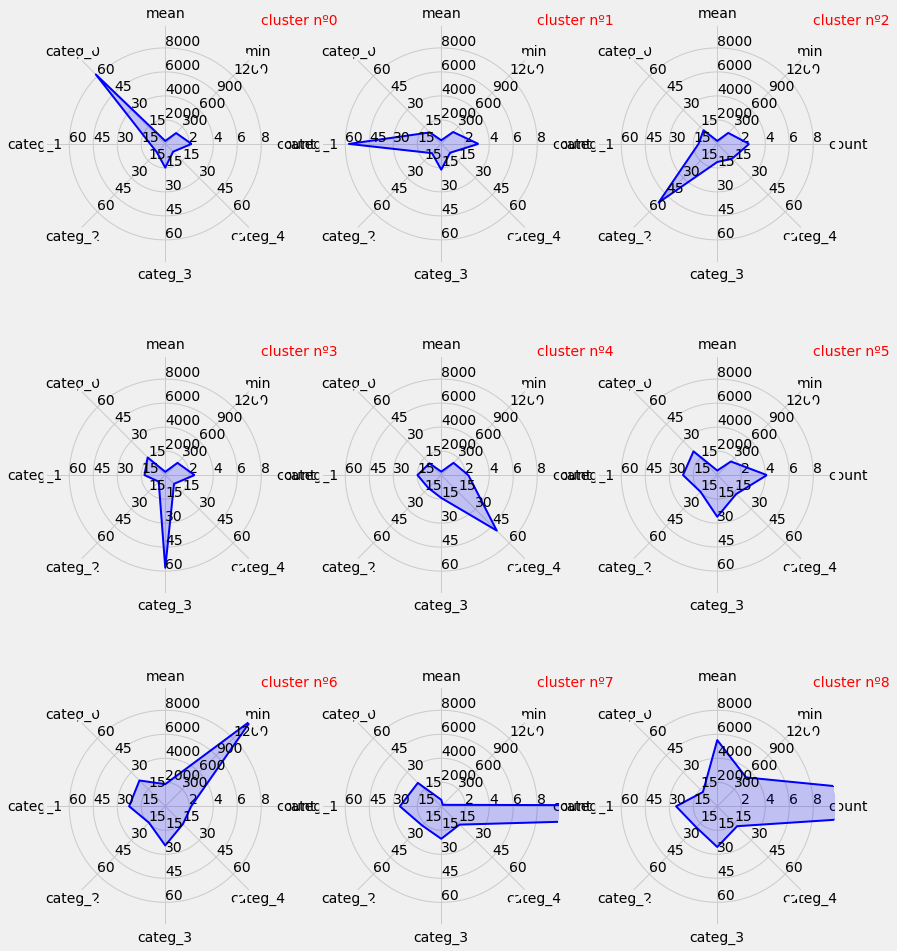

In [153]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'min', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

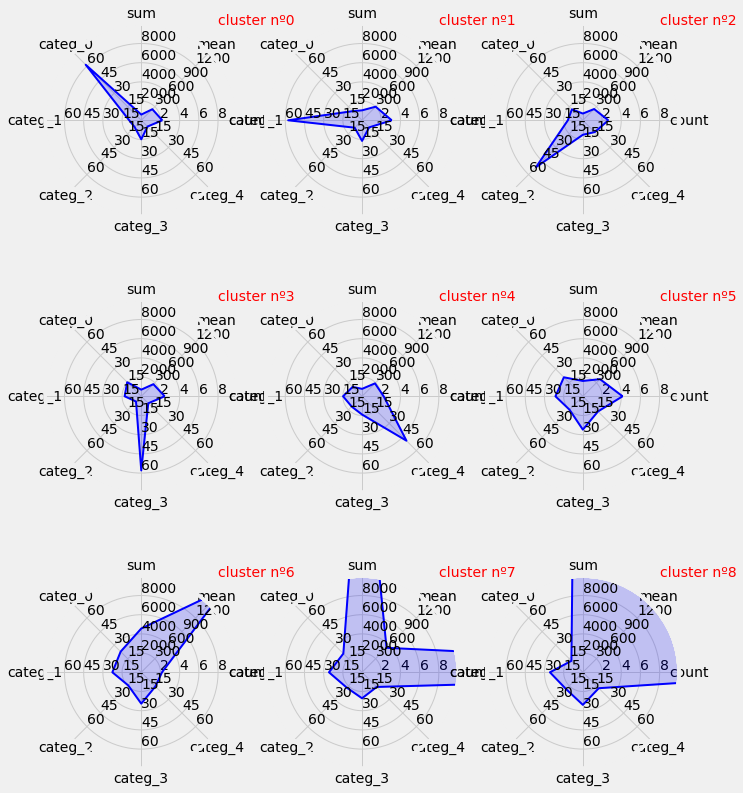

In [149]:
fig = plt.figure(figsize=(8,10))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

####Predictions

In [0]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [0]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [166]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=10)  
classifier.fit(X_train, Y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [173]:
pred_train = classifier.predict(X_train)
print(classification_report(Y_train, pred_train))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       291
           1       0.98      0.75      0.85       285
           2       0.71      0.93      0.81        83
           3       0.96      0.81      0.88       281
           4       0.78      0.98      0.87      1283
           5       0.98      0.66      0.79       279
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         4
           8       0.97      0.75      0.85       361

    accuracy                           0.85      2886
   macro avg       0.70      0.63      0.66      2886
weighted avg       0.87      0.85      0.85      2886



In [0]:
y_pred = classifier.predict(X_test)

In [174]:
from sklearn.metrics import classification_report, confusion_matrix    
print(classification_report(Y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        69
           1       0.98      0.70      0.82        67
           2       0.66      0.92      0.77        25
           3       0.97      0.75      0.85        85
           4       0.76      0.97      0.85       328
           5       0.97      0.56      0.71        57
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.97      0.68      0.80        84

    accuracy                           0.83       722
   macro avg       0.69      0.60      0.63       722
weighted avg       0.85      0.83      0.82       722



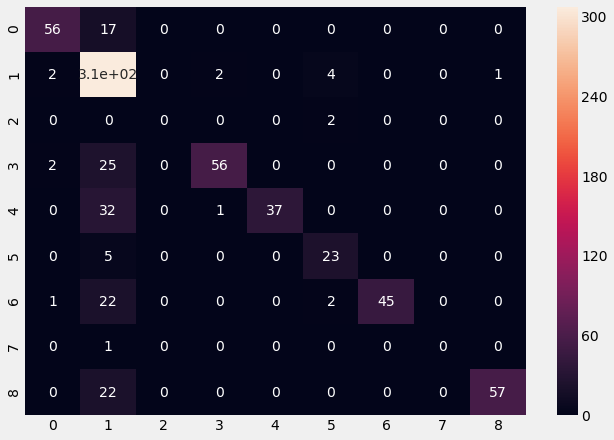

In [75]:
import seaborn as sn
cnf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cnf_matrix, annot=True)

#### Canceled orders

In [0]:
#retrieve the list of products:
cancel_produits = pd.DataFrame(df_cancel['Description'].unique()).rename(columns = {0:'Description'})

In [182]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(cancel_produits)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Nb of keywords in variable 'Description': 993


In [0]:
list_cancelproducts = []
for k,v in count_keywords.items():
    list_cancelproducts.append([keywords_select[k],v])
list_cancelproducts.sort(key = lambda x:x[1], reverse = True)

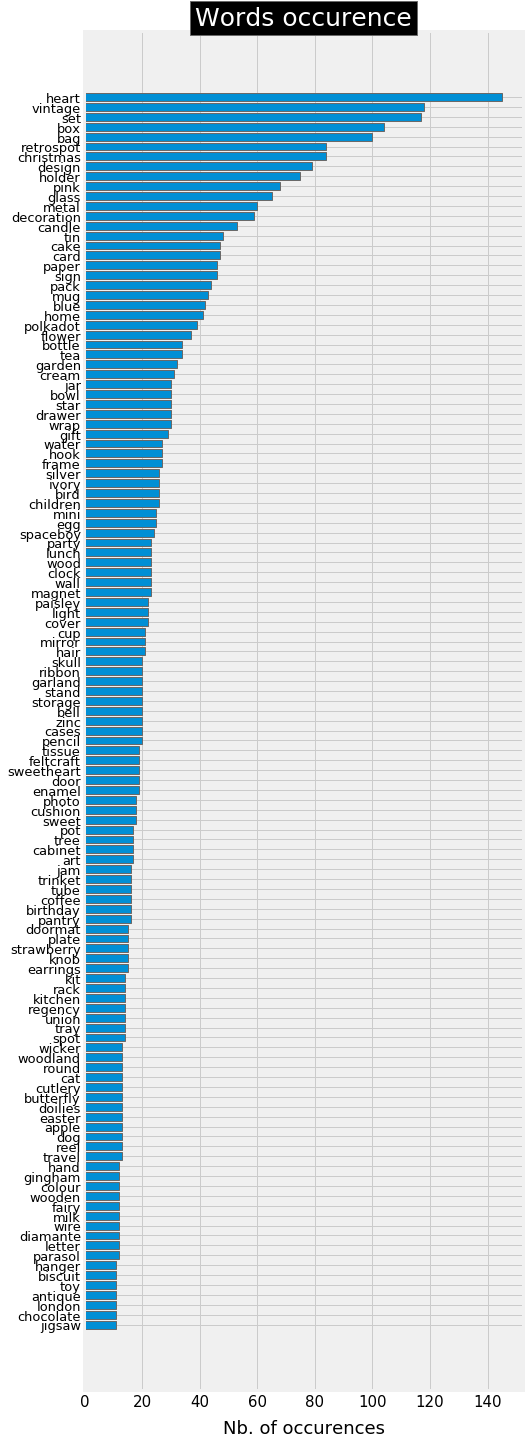

In [184]:
liste = sorted(list_cancelproducts, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [185]:
list_cancelproducts = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_cancelproducts.append([word, v])
#______________________________________________________    
list_cancelproducts.sort(key = lambda x:x[1], reverse = True)
print('most frequent word:', len(list_cancelproducts))

most frequent word: 106


In [186]:
list_cancelproducts[:10]

[['heart', 145],
 ['vintage', 118],
 ['set', 117],
 ['box', 104],
 ['bag', 100],
 ['retrospot', 84],
 ['christmas', 84],
 ['design', 79],
 ['holder', 75],
 ['glass', 65]]

In [0]:
liste_cancelproduits = df_cancel['Description'].unique()
X_c = pd.DataFrame()
for key, occurence in list_cancelproducts:
    X_c.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_cancelproduits))

In [0]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X_c.loc[:, col] = 0

for i, prod in enumerate(liste_cancelproduits):
    prix = df_cancel[ df_cancel['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X_c.loc[i, label_col[j-1]] = 1

In [189]:
X_c.head()

,heart,vintage,set,box,bag,retrospot,christmas,design,holder,glass,metal,decoration,candle,tin,cake,card,paper,sign,pack,mug,home,polkadot,flower,bottle,tea,garden,cream,jar,bowl,star,drawer,wrap,gift,water,hook,frame,silver,ivory,bird,children,...,pot,tree,cabinet,art,jam,trinket,tube,coffee,birthday,pantry,doormat,plate,strawberry,knob,earrings,kit,rack,kitchen,regency,union,tray,spot,wicker,woodland,round,cat,cutlery,butterfly,doilies,easter,apple,dog,reel,travel,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [190]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X_c.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       444                 
1<.<2       553                 
2<.<3       328                 
3<.<5       289                 
5<.<10      242                 
.>10        89                  


K modes for Cancelled products

In [191]:
from kmodes.kmodes import KModes
for n_clusters_c in range(3,10):
  km = KModes(n_clusters=n_clusters_c, init='Huang', n_init=5, verbose=1)

  clusters_c = km.fit_predict(X_c)

  silhouette_avg = silhouette_score(X_c, clusters_c)
  print("For n_clusters =", n_clusters_c, "The average silhouette_score is :", silhouette_avg)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10, cost: 5896.0
Run 1, iteration: 2/100, moves: 0, cost: 5896.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 100, cost: 5549.0
Run 2, iteration: 2/100, moves: 0, cost: 5549.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 23, cost: 5881.0
Run 3, iteration: 2/100, moves: 0, cost: 5881.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 52, cost: 5780.0
Run 4, iteration: 2/100, moves: 0, cost: 5780.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 208, cost: 5843.0
Run 5, iteration: 2/100, moves: 2, cost: 5843.0
Best run was number 2
For n_clusters = 3 The average silhouette_score is : 0.1147698059178692
Init: initializing 

In [192]:
n_clusters_c = 5
kmode = KModes(n_clusters=n_clusters_c, init='Huang', n_init=5, verbose=1)
clusters_c = kmode.fit_predict(X_c)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 180, cost: 5688.0
Run 1, iteration: 2/100, moves: 1, cost: 5688.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 30, cost: 6001.0
Run 2, iteration: 2/100, moves: 0, cost: 6001.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 77, cost: 5501.0
Run 3, iteration: 2/100, moves: 0, cost: 5501.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 46, cost: 5583.0
Run 4, iteration: 2/100, moves: 0, cost: 5583.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 30, cost: 4624.0
Run 5, iteration: 2/100, moves: 0, cost: 4624.0
Best run was number 5


In [193]:
pd.Series(clusters_c).value_counts()

1    553
4    444
0    378
2    328
3    242
dtype: int64

In [0]:
liste = pd.DataFrame(liste_cancelproduits)
liste_words = [word for (word, occurence) in list_cancelproducts]

occurence = [dict() for _ in range(n_clusters_c)]

for i in range(n_clusters_c):
    liste_cluster = liste.loc[clusters_c == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

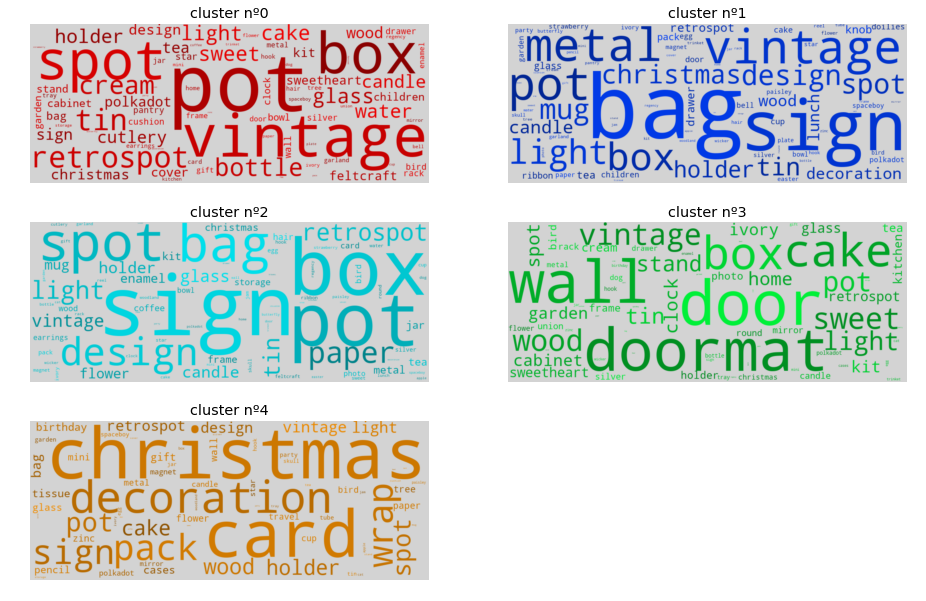

In [195]:

#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters_c):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)